In [6]:
!pip install torch torchvision transformers datasets matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from PIL import Image


In [8]:
from datasets import Dataset, DatasetDict

# Create a function to load images
def load_images_from_folder(folder_path):
    image_paths = []
    labels = []
    label_map = {}  # map folder names to integer labels
    for label, folder in enumerate(os.listdir(folder_path)):
        folder_dir = os.path.join(folder_path, folder)
        if os.path.isdir(folder_dir):
            for image_name in os.listdir(folder_dir):
                image_path = os.path.join(folder_dir, image_name)
                if image_path.endswith('.jpg') or image_path.endswith('.png'):
                    image_paths.append(image_path)
                    labels.append(label)
            label_map[label] = folder
    return image_paths, labels, label_map

# Example: loading from a local folder
folder_path = '/content/sample_data'
image_paths, labels, label_map = load_images_from_folder(folder_path)

# Creating a Dataset
dataset = Dataset.from_dict({"image": image_paths, "label": labels})

# Split into train and validation datasets
train_test_split = dataset.train_test_split(test_size=0.2)
dataset = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})


In [9]:
# Initialize the ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Define the transformation for image preprocessing
def preprocess_function(examples):
    # Open the image files
    images = [Image.open(img_path).convert("RGB") for img_path in examples['image']]
    # Preprocess the images with ViT feature extractor
    return feature_extractor(images=images, return_tensors="pt")

# Apply the preprocessing to the entire dataset
dataset = dataset.map(preprocess_function, batched=True)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Map:   0%|          | 0/492 [00:00<?, ? examples/s]

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

In [10]:
# Load the pretrained ViT model with a classification head
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(label_map)  # Number of classes in your dataset
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Create DataLoader for training and testing datasets
batch_size = 16

train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False)


In [21]:
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_dataloader:
        inputs = batch['pixel_values']

        if isinstance(inputs, list):
            processed_inputs = []
            for i, img in enumerate(inputs):
                if isinstance(img, (Image.Image, np.ndarray)):
                    try:
                        processed_inputs.append(to_tensor(img))
                    except Exception as e:
                        print(f"Error processing image {i}: {e}")
                else:
                    print(f"Skipping invalid img[{i}] of type {type(img)}")

            if processed_inputs:
                inputs = torch.stack(processed_inputs).to(device)
            else:
                print("No valid inputs to process in this batch. Skipping...")
                continue  # Skip this batch if no valid inputs

        elif isinstance(inputs, torch.Tensor):
            inputs = inputs.to(device)
        else:
            print(f"Unexpected input type: {type(inputs)}. Skipping batch...")
            continue

        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(train_dataloader)

    if total_preds > 0:  # Avoid division by zero
        accuracy = correct_preds / total_preds * 100
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    else:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, No predictions made.")


Skipping invalid img[0] of type <class 'list'>
Skipping invalid img[1] of type <class 'list'>
Skipping invalid img[2] of type <class 'list'>
No valid inputs to process in this batch. Skipping...
Skipping invalid img[0] of type <class 'list'>
Skipping invalid img[1] of type <class 'list'>
Skipping invalid img[2] of type <class 'list'>
No valid inputs to process in this batch. Skipping...
Skipping invalid img[0] of type <class 'list'>
Skipping invalid img[1] of type <class 'list'>
Skipping invalid img[2] of type <class 'list'>
No valid inputs to process in this batch. Skipping...
Skipping invalid img[0] of type <class 'list'>
Skipping invalid img[1] of type <class 'list'>
Skipping invalid img[2] of type <class 'list'>
No valid inputs to process in this batch. Skipping...
Skipping invalid img[0] of type <class 'list'>
Skipping invalid img[1] of type <class 'list'>
Skipping invalid img[2] of type <class 'list'>
No valid inputs to process in this batch. Skipping...
Skipping invalid img[0] o

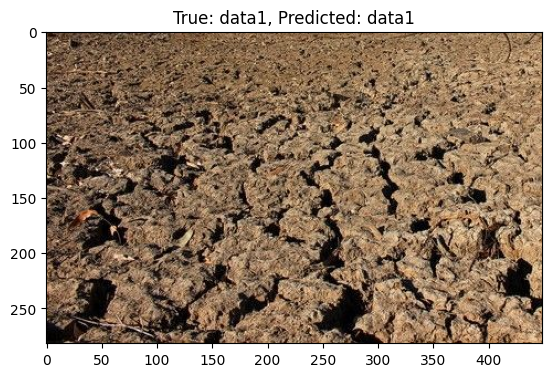

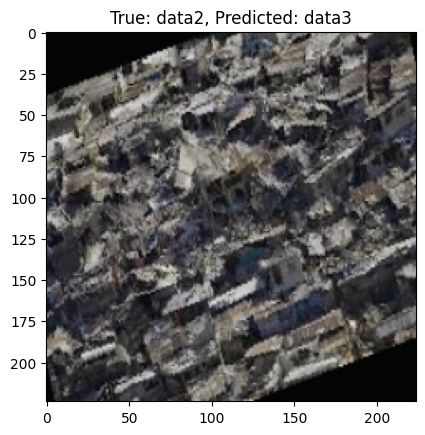

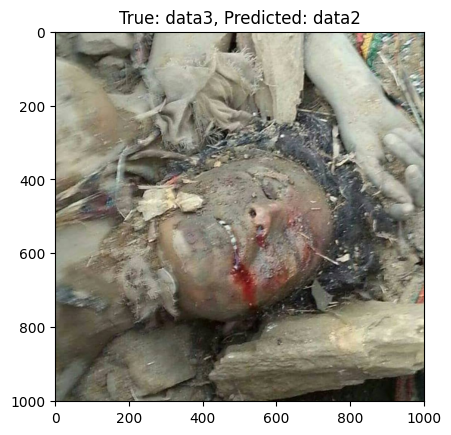

In [22]:
# Visualize predictions on some test images
model.eval()
sample = dataset['test'].shuffle(seed=42).select([0, 1, 2])  # Select a few samples for visualization

for item in sample:
    img = Image.open(item['image'])
    label = item['label']
    output = model(feature_extractor(images=[img], return_tensors="pt").pixel_values.to(device))
    prediction = torch.argmax(output.logits, dim=1).item()

    plt.imshow(img)
    plt.title(f"True: {label_map[label]}, Predicted: {label_map[prediction]}")
    plt.show()
